## MIE451/1513 Decision Support System -- Data Science Lab

## Install packages

In [1]:
# check the current python version
import sys
print(sys.version)

3.7.12 (default, Jan 15 2022, 18:48:18) 
[GCC 7.5.0]


In [2]:
!pip install folium
!pip install tqdm
!pip install numpy
!pip install pandas
!pip install nltk
!pip install scikit-learn
!pip install scipy
!pip install geopy
!pip install tabulate
!pip install textblob
!pip install spacy
!python -m spacy download en_core_web_sm

     |████████████████████████████████| 12.0 MB 7.1 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [3]:
#Plot
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#Data Packages
import math
import pandas as pd
import numpy as np

#Progress bar
from tqdm import tqdm

#Counter
from collections import Counter

#Operation
import operator

#Natural Language Processing Packages
import re
import nltk

## Download Resources
nltk.download("vader_lexicon")
nltk.download("stopwords")
nltk.download("averaged_perceptron_tagger")
nltk.download("wordnet")

from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
from nltk import tokenize
from nltk.corpus import stopwords
from nltk.tag import PerceptronTagger
from nltk.data import find

## Machine Learning
import sklearn
import sklearn.metrics as metrics

## Data Visualization
import folium
from tabulate import tabulate
from scipy.stats.kde import gaussian_kde

## Geolocation
import geopy
from geopy.geocoders import Photon
from geopy.extra.rate_limiter import RateLimiter

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [4]:
pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', 500)

# Sentiment Analysis using Vader - Simple Examples

In [5]:
#Example sentences
sentences = ["VADER is smart, handsome, and funny.",
        "Professor Eldan is a great professor with excellent teaching skills and research ability",
        "Max is a good programmer, he is very good at Python and Java",
        "Jason is a bad programmer, he is completely ignorant about programming",
        "MIEXXX is such a boring course, the projects are too long to finish",
        "MIE1513 is a very intersting course which is taught by a great professor and has very useful knowledge"]


In [6]:
# Use vader to evaluated sentiment of reviews
def evalSentences(sentences, to_df=False, columns=[]):
    #Instantiate an instance to access SentimentIntensityAnalyzer class
    sid = SentimentIntensityAnalyzer()
    pdlist = []
    if to_df:
        for sentence in tqdm(sentences):
            ss = sid.polarity_scores(sentence)
            pdlist.append([sentence]+[ss['compound']])
        reviewDf = pd.DataFrame(pdlist)
        reviewDf.columns = columns
        return reviewDf
    
    else:
        for sentence in tqdm(sentences):
            print(sentence)
            ss = sid.polarity_scores(sentence)
            for k in sorted(ss):
                print('{0}: {1}, '.format(k, ss[k]), end='')
            print()

In [7]:
evalSentences(sentences)

100%|██████████| 6/6 [00:00<00:00, 1994.75it/s]

VADER is smart, handsome, and funny.
compound: 0.8316, neg: 0.0, neu: 0.254, pos: 0.746, 
Professor Eldan is a great professor with excellent teaching skills and research ability
compound: 0.8779, neg: 0.0, neu: 0.471, pos: 0.529, 
Max is a good programmer, he is very good at Python and Java
compound: 0.7003, neg: 0.0, neu: 0.633, pos: 0.367, 
Jason is a bad programmer, he is completely ignorant about programming
compound: -0.7089, neg: 0.424, neu: 0.576, pos: 0.0, 
MIEXXX is such a boring course, the projects are too long to finish
compound: -0.3182, neg: 0.173, neu: 0.827, pos: 0.0, 
MIE1513 is a very intersting course which is taught by a great professor and has very useful knowledge
compound: 0.807, neg: 0.0, neu: 0.657, pos: 0.343, 


# Working with real review data

We will use a small sample of hotel reviews from Niagara Falls that has been precompiled

In [8]:
#Read in from pandas
columnNames = ['filePath','hotelName','reviewColumn','ratingScore','groundTruth',
          'date_stamp','streetAddress', 'City',
          'Province','postalCode']

hotelDf = pd.read_csv('https://github.com/MIE1513HS-2022/course-datasets/raw/main/niagara-falls-sample.csv',
                          header=None,
                          names=columnNames)

In [9]:
hotelDf.head()

,filePath,hotelName,reviewColumn,ratingScore,groundTruth,date_stamp,streetAddress,City,Province,postalCode
0,data/ca/154998/252855/169478164.html,Niagara Falls Motor Lodge,"""The kindness of the owners\u002Fstaff of this place is what makes this place stand out from all other roadside motels. The rooms are clean and have the basic necessities for a stay (far better than a Motel 6 or a Super 8), the cost is a fraction of the Niagara Falls ripoffs, but the staff was amazing. We were planning a cycling loop and the owner graciously offered to let us leave our car in the parking lot for the 2 days that we cycled the Niagara loop. The adjoining pub is a delight fo...",5,positive,"July 28, 2013",7950 Portage Rd at Legion Street,Niagara Falls,Ontario,L2G 5Y8
1,data/ca/154998/252855/313404035.html,Niagara Falls Motor Lodge,"""We chose this motel because #1 Price was cheaper than the others that raised their rates on weekends, and #2 the location, although not ideal was close to the Niagara Parkway and their parking lots. The pluses for this facility are price, location, and personal service. The building itself needs renovation, upgrading, and a general sprucing up. There are breakfast and dinner restaurants nearby, and it is close-in to the main area. A place to sleep at a reasonable price",2,negative,"September 24, 2015",7950 Portage Rd at Legion Street,Niagara Falls,Ontario,L2G 5Y8
2,data/ca/154998/252855/745054547.html,Niagara Falls Motor Lodge,"""Decided to take a weekend away with friends for a mini getaway. Needed two rooms. Hotel was very accommodating. Asked for two rooms close to each other. Rooms well kept and maintained. Staff very polite. Would recommend hotel. Will be back again. Thanks for the fun weekend away. Very affordable",5,positive,"February 14, 2020",7950 Portage Rd at Legion Street,Niagara Falls,Ontario,L2G 5Y8
3,data/ca/154998/252855/336928892.html,Niagara Falls Motor Lodge,"""We drove to Niagara Falls with no reservations or specific plans. Searching for a hotel on the phone, we found this one at a great price. The location was perfect if you don't want to be in the thick of the tourists. It's really in a little town just outside Niagara called Chipewa, where there are a few restaurants and pubs. The hotel owner waited for our arrival and showed us to our room, which was very clean and well appointed. Highly recommend if you want a simple inexpensive place to st...",4,positive,"January 3, 2016",7950 Portage Rd at Legion Street,Niagara Falls,Ontario,L2G 5Y8
4,data/ca/154998/252855/541347996.html,Niagara Falls Motor Lodge,"""Awful, the rooms were filthy, during my stay so far the room has not been cleaned nor the beds made. Reception is hardly open. Apparently my room only has 1 Key so my room cannot be serviced. Plaster is hanging off the ceiling. damp patches on ceiling. walls filthy and scuffed. Coffee maker next to to toilet within bathroom, hardly health and safe compliant or hygenic. Complete lack of assistance from staff. If you prepay your bill I would advise you to check it carefully as I was way overc...",1,negative,"November 16, 2017",7950 Portage Rd at Legion Street,Niagara Falls,Ontario,L2G 5Y8


## Sentiment Analysis

 The raw reivews can be fed directly into Vader. Alternatively some data cleaning could be conducted before this step

In [10]:
reviews = hotelDf['reviewColumn'].values

In [11]:
reviewDF = evalSentences(reviews, to_df=True, columns=['reviewCol','vader'])

100%|██████████| 2527/2527 [00:07<00:00, 340.39it/s]


In [12]:
reviewDF.head()

,reviewCol,vader
0,"""The kindness of the owners\u002Fstaff of this place is what makes this place stand out from all other roadside motels. The rooms are clean and have the basic necessities for a stay (far better than a Motel 6 or a Super 8), the cost is a fraction of the Niagara Falls ripoffs, but the staff was amazing. We were planning a cycling loop and the owner graciously offered to let us leave our car in the parking lot for the 2 days that we cycled the Niagara loop. The adjoining pub is a delight fo...",0.9915
1,"""We chose this motel because #1 Price was cheaper than the others that raised their rates on weekends, and #2 the location, although not ideal was close to the Niagara Parkway and their parking lots. The pluses for this facility are price, location, and personal service. The building itself needs renovation, upgrading, and a general sprucing up. There are breakfast and dinner restaurants nearby, and it is close-in to the main area. A place to sleep at a reasonable price",-0.4168
2,"""Decided to take a weekend away with friends for a mini getaway. Needed two rooms. Hotel was very accommodating. Asked for two rooms close to each other. Rooms well kept and maintained. Staff very polite. Would recommend hotel. Will be back again. Thanks for the fun weekend away. Very affordable",0.9211
3,"""We drove to Niagara Falls with no reservations or specific plans. Searching for a hotel on the phone, we found this one at a great price. The location was perfect if you don't want to be in the thick of the tourists. It's really in a little town just outside Niagara called Chipewa, where there are a few restaurants and pubs. The hotel owner waited for our arrival and showed us to our room, which was very clean and well appointed. Highly recommend if you want a simple inexpensive place to st...",0.9232
4,"""Awful, the rooms were filthy, during my stay so far the room has not been cleaned nor the beds made. Reception is hardly open. Apparently my room only has 1 Key so my room cannot be serviced. Plaster is hanging off the ceiling. damp patches on ceiling. walls filthy and scuffed. Coffee maker next to to toilet within bathroom, hardly health and safe compliant or hygenic. Complete lack of assistance from staff. If you prepay your bill I would advise you to check it carefully as I was way overc...",-0.3744


## Find the most sentimental words by Mutual Information

### First we need to do some precprocessing
1. Find Top-K words (you will need to do some preprocessing in the assignment)
2. Build a dataframe with one-hot encoding for words present in each review

In [13]:
def get_stop_words():
    stop = set(stopwords.words('english'))
    #Add possible Stop Words for Hotel Reviews
    stop.add('hotel')
    stop.add('room')
    stop.add('rooms')
    stop.add('stay')
    stop.add('staff')
    return stop

def getTopKWords(df, kwords):

    stop = get_stop_words()
    counter = Counter()

    reviews = df['reviewCol'].values

    for review in reviews:
            counter.update([word.lower() 
                            for word 
                            in re.findall(r'\w+', review) 
                            if word.lower() not in stop and len(word) > 2])
    topk = counter.most_common(kwords)
    return topk

# Note: You may want to use an NLTK tokenizer instead of a regular expression in the following
def dataFrameTransformation(hotelDf, reviewDF, topk):
    reviews = reviewDF['reviewCol'].values
    
    #Find out if a particular review has the word from topk list
    freqReview = []
    for i in range(len(reviews)):
        tempCounter = Counter([word.lower() for word in re.findall(r'\w+',reviews[i])])
        topkinReview = [1 if tempCounter[word] > 0 else 0 for (word,wordCount) in topk]
        freqReview.append(topkinReview)
        
        
    #Prepare freqReviewDf
    freqReviewDf = pd.DataFrame(freqReview)
    dfName = []
    for c in topk:
        dfName.append(c[0])
    freqReviewDf.columns = dfName
    finalreviewDf = reviewDF.join(freqReviewDf)
    finaldf = hotelDf[['hotelName','ratingScore','groundTruth']].join(finalreviewDf)
    return finaldf


In [14]:
topk = getTopKWords(reviewDF, 500)
finaldf = dataFrameTransformation(hotelDf, reviewDF, topk)

In [15]:
topk[:10]

[('falls', 1516),
 ('clean', 1284),
 ('breakfast', 1174),
 ('would', 1136),
 ('great', 1027),
 ('place', 1013),
 ('good', 881),
 ('one', 870),
 ('nice', 816),
 ('niagara', 784)]

In [16]:
finaldf.head()

,hotelName,ratingScore,groundTruth,reviewCol,vader,falls,clean,breakfast,would,great,place,good,one,nice,niagara,night,bed,stayed,parking,time,like,location,back,also,get,area,friendly,walk,comfortable,could,pool,well,day,even,nthe,bathroom,check,u2019t,front,really,motel,price,close,recommend,people,free,service,everything,first,two,booked,got,desk,made,little,away,family,next,door,coffee,water,floor,view,walking,morning,definitely,around,told,said,went,right,beds,small,tub,hot,home,nights,helpful,see,experience,quiet,want,much,staying,old,distance,never,shower,hotels,inn,outside,fridge,best,lot,u2019s,dirty,nwe,another,make,enough,use,amazing,house,park,kids,sure,asked,looking,wonderful,found,minutes,way,come,find,going,take,enjoyed,food,many,better,weekend,hill,money,extra,guests,excellent,clifton,perfect,need,attractions,ever,bit,lovely,bad,booking,available,beautiful,property,say,still,minute,feel,owner,looked,new,pay,wifi,towels,trip,came,work,big,arrived,sleep,easy,days,called,left,since,nothing,visit,however,bus,give,large,car,last,open,hosts,times,husband,felt,reviews,always,delicious,gave,long,know,within,wanted,though,spacious,full,site,located,checked,street,suite,far,every,highly,owners,couple,think,restaurants,lots,book,took,king,thing,quite,jacuzzi,loved,year,things,main,needed,side,return,host,overall,wife,restaurant,included,casino,paid,super,air,years,charge,extremely,covid,friends,microwave,places,drive,decided,second,something,able,across,short,else,pretty,worth,put,anything,manager,late,let,value,kind,early,size,thought,pleasant,leave,phone,etc,balcony,fine,used,may,call,needs,fresh,spent,given,due,near,enjoy,per,part,fruit,window,working,accommodating,keep,smell,look,although,warm,without,toilet,anyone,run,charged,cold,problem,hard,customer,welcoming,actually,provided,noise,eggs,plus,different,u201d,sheets,building,safe,queen,cheap,rate,eat,upon,comfy,hair,stop,care,worked,worst,reasonable,someone,thank,try,three,kept,deal,river,walls,getting,fee,disgusting,top,table,basic,offered,cleaned,convenient,bring,refund,dinner,help,carpet,town,happy,person,seemed,lobby,card,wall,issue,reservation,breakfasts,canada,closed,lady,whole,quality,hours,inside,coming,disappointed,absolutely,love,walked,amenities,wait,decent,high,expect,later,quick,least,ask,issues,loud,com,downtown,served,tried,cost,awesome,star,evening,bath,pillows,done,non,fallsview,pictures,huge,road,dated,elevator,office,broken,rude,local,guest,especially,end,visiting,wego,fantastic,checking,cleaning,tourist,offer,expected,spend,fun,along,arrival,busy,either,expensive,everyone,tell,chairs,saw,hour,toast,tea,less,gary,everywhere,light,decorated,private,almost,several,probably,seen,choice,group,reception,management,outdated,stains,ice,wine,special,smelled,thanks,filthy,instead,man,yes,cozy,plenty,mini,yet,sink,website,terrible,nit,making,anniversary,ended,juice,change,100,maker,start,older,maybe,city,line,machine,nthis,past,hear,welcome,bugs,review,sites,received,smoking,read,online,horrible,budget,must,cannot,name,please,dining,recently,somewhere,head,four,prices,vacation,slept,set,space,already,key,noticed,turned,business,might,canadian,double,access,wrong,order,mind,half,smoke,mold,paper,affordable,channels,point,recommended,children,information,travel,windows,floors,week
0,Niagara Falls Motor Lodge,5,positive,"""The kindness of the owners\u002Fstaff of this place is what makes this place stand out from all other roadside motels. The rooms are clean and have the basic necessities for a stay (far better than a Motel 6 or a Super 8), the cost is a fraction of the Niagara Falls ripoffs, but the staff was amazing. We were planning a cycling loop and the owner graciously offered to let us leave our car in the parking lot for the 2 days that we cycled the Niagara loop. The adjoining pub is a delight fo...",0.9915,1,1,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [17]:
topk[:10]

[('falls', 1516),
 ('clean', 1284),
 ('breakfast', 1174),
 ('would', 1136),
 ('great', 1027),
 ('place', 1013),
 ('good', 881),
 ('one', 870),
 ('nice', 816),
 ('niagara', 784)]

### Compute Mutual Information (MI)

Now that the data is the appropriate form we can calculate the mutual information for the topK words.

In [18]:
# get Top K mutual information terms from the dataframe
def getMI(topk, df, label_column='groundTruth'):
    miScore = []
    for word in topk:
        miScore.append([word[0]]+[metrics.mutual_info_score(finaldf[label_column], finaldf[word[0]])])
    miScoredf = pd.DataFrame(miScore).sort_values(1,ascending=0)
    miScoredf.columns = ['Word','MI Score']
    return miScoredf

In [19]:
miScoredf = getMI(topk, finaldf)

In [20]:
miScoredf.head()

,Word,MI Score
90,dirty,0.052169
62,told,0.040363
4,great,0.035804
0,falls,0.032374
309,disgusting,0.028552


### Compute Pointwise Mutual Information (PMI)


In [21]:
# Simple example of getting pointwise mutual information of a term

def demo_pmiCal(df,word):
    pmilist=[]
    N = df.shape[0]
    for sentiment in ['positive','negative']:
        for word_present in [False,True]:
            px = sum(df['groundTruth']==sentiment)
            py = sum(df[word]==word_present)
            pxy = len(df[(df['groundTruth']==sentiment) & (df[word]==word_present)])

            if pxy==0:#Log 0 cannot happen
                pmi = math.log((pxy+0.0001)*N/(px*py))
            else:
                pmi = math.log(pxy*N/(px*py))

            pmilist.append([sentiment]+[word_present]+[px]+[py]+[pxy]+[pmi])

    # assemble the results into a dataframe
    pmidf = pd.DataFrame(pmilist)
    pmidf.columns = ['sentiment (x)','word_present (y)','px','py','pxy','pmi']
    return pmidf

In [22]:
demo_pmiCal(finaldf,'great')
# TODO: ask Eldan about the "groundTruth" and the "sentiment(x)"

,sentiment (x),word_present (y),px,py,pxy,pmi
0,positive,False,1538,1760,924,-0.147807
1,positive,True,1538,767,614,0.274058
2,negative,False,989,1760,836,0.193653
3,negative,True,989,767,153,-0.673955


In [23]:
# Compute PMI for all terms and all possible labels
def pmiForAllCal(df, topk_word, gt_sentiment, label_column='groundTruth'):
    #Try calculate all the pmi for top k and store them into one pmidf dataframe
    
    index = [x[0] for x in topk_word]
    pmiDf = pd.DataFrame(index=index, columns=['pmi'])

    for (word, count) in tqdm(topk_word):
        pmiDf.at[word, 'pmi'] = pmiCalc(df,word,gt_sentiment,label_column)
    
    return pmiDf


def pmiCalc(df, word, gt_sentiment, label_column='groundTruth'):
    
    N = df.shape[0]
    
    px = sum(df[label_column]==gt_sentiment)
    py = sum(df[word]==True)
    pxy = len(df[(df[label_column]==gt_sentiment) & (df[word]==True)])

    if pxy==0:#Log 0 cannot happen
        pmi = math.log((pxy+0.0001)*N/(px*py))
    else:
        pmi = math.log(pxy*N/(px*py))
    return pmi

In [24]:
pmiposdf = pmiForAllCal(finaldf,topk,'positive')

100%|██████████| 500/500 [00:03<00:00, 157.04it/s]


In [25]:
#Sorted top pmi words for positive reviews
pmiposdf.sort_values('pmi',ascending=0).head(5)

,pmi
gary,0.469882
decorated,0.466245
hosts,0.462182
highly,0.45429
delicious,0.45003


In [26]:
#Sorted top pmi words for negative reviews
pminegdf = pmiForAllCal(finaldf,topk,'negative')
pminegdf.sort_values('pmi',ascending=0).head(5)

100%|██████████| 500/500 [00:03<00:00, 156.17it/s]


,pmi
disgusting,0.938094
refund,0.922826
filthy,0.918291
broken,0.908241
worst,0.90128


In [27]:
demo_pmiCal(finaldf,'gary')

,sentiment (x),word_present (y),px,py,pxy,pmi
0,positive,False,1538,2489,1501,-0.009200
1,positive,True,1538,38,37,0.469882
2,negative,False,989,2489,988,0.014140
3,negative,True,989,38,1,-2.699492


### Get TopK words based on review sentiment

In [28]:
def getTopK(df, kwords, label_value, label_column='groundTruth', operation=operator.eq, value_column='reviewCol'):
    stop = get_stop_words()
    counter = Counter()
    reviews = df.loc[operation(df[label_column],label_value)][value_column]
    for review in reviews:
          counter.update([word.lower() 
                          for word 
                          in re.findall(r'\w+', review) 
                          if word.lower() not in stop and len(word) > 2])
    topk = counter.most_common(kwords)
    return topk

In [29]:
#We are only intereseted in this three column for overall analysis
itemAnalysisDf = finaldf[['reviewCol','groundTruth','vader']]
itemAnalysisDf.head()

,reviewCol,groundTruth,vader
0,"""The kindness of the owners\u002Fstaff of this place is what makes this place stand out from all other roadside motels. The rooms are clean and have the basic necessities for a stay (far better than a Motel 6 or a Super 8), the cost is a fraction of the Niagara Falls ripoffs, but the staff was amazing. We were planning a cycling loop and the owner graciously offered to let us leave our car in the parking lot for the 2 days that we cycled the Niagara loop. The adjoining pub is a delight fo...",positive,0.9915
1,"""We chose this motel because #1 Price was cheaper than the others that raised their rates on weekends, and #2 the location, although not ideal was close to the Niagara Parkway and their parking lots. The pluses for this facility are price, location, and personal service. The building itself needs renovation, upgrading, and a general sprucing up. There are breakfast and dinner restaurants nearby, and it is close-in to the main area. A place to sleep at a reasonable price",negative,-0.4168
2,"""Decided to take a weekend away with friends for a mini getaway. Needed two rooms. Hotel was very accommodating. Asked for two rooms close to each other. Rooms well kept and maintained. Staff very polite. Would recommend hotel. Will be back again. Thanks for the fun weekend away. Very affordable",positive,0.9211
3,"""We drove to Niagara Falls with no reservations or specific plans. Searching for a hotel on the phone, we found this one at a great price. The location was perfect if you don't want to be in the thick of the tourists. It's really in a little town just outside Niagara called Chipewa, where there are a few restaurants and pubs. The hotel owner waited for our arrival and showed us to our room, which was very clean and well appointed. Highly recommend if you want a simple inexpensive place to st...",positive,0.9232
4,"""Awful, the rooms were filthy, during my stay so far the room has not been cleaned nor the beds made. Reception is hardly open. Apparently my room only has 1 Key so my room cannot be serviced. Plaster is hanging off the ceiling. damp patches on ceiling. walls filthy and scuffed. Coffee maker next to to toilet within bathroom, hardly health and safe compliant or hygenic. Complete lack of assistance from staff. If you prepay your bill I would advise you to check it carefully as I was way overc...",negative,-0.3744


In [30]:
topkGroundPos = getTopK(itemAnalysisDf, 10, label_value='positive')
topkGroundPos

[('falls', 1139),
 ('clean', 928),
 ('breakfast', 875),
 ('great', 849),
 ('niagara', 583),
 ('nice', 575),
 ('good', 548),
 ('would', 546),
 ('place', 522),
 ('stayed', 482)]

In [31]:
topkGroundNeg = getTopK(itemAnalysisDf, 10, label_value='negative')
topkGroundNeg

[('would', 590),
 ('one', 498),
 ('place', 491),
 ('night', 451),
 ('falls', 377),
 ('like', 359),
 ('clean', 356),
 ('bed', 354),
 ('get', 351),
 ('even', 334)]

In [32]:
# for vader, greater than 0 is positive
topkVaderPos = getTopK(itemAnalysisDf, 
                       10, 
                       label_value=0, 
                       label_column='vader', 
                       operation=operator.gt)

topkVaderPos

[('falls', 1395),
 ('clean', 1174),
 ('breakfast', 1079),
 ('great', 985),
 ('would', 869),
 ('good', 800),
 ('nice', 770),
 ('place', 749),
 ('niagara', 708),
 ('one', 647)]

In [33]:
topkVaderNeg = getTopK(itemAnalysisDf, 
                       10, 
                       label_value=0, 
                       label_column='vader', 
                       operation=operator.lt)

topkVaderNeg

[('would', 266),
 ('place', 264),
 ('one', 222),
 ('night', 196),
 ('dirty', 184),
 ('bed', 182),
 ('even', 167),
 ('get', 165),
 ('told', 163),
 ('like', 141)]

# Ranking the hotels

In [34]:
#Extract a list of hotels
# this of course may need to be filtered 
hotelNames = finaldf['hotelName'].unique()
hotelNames[:10]

array(['Niagara Falls Motor Lodge', 'Dutch Inn Motel',
       'Two Rivers Bed &amp; Breakfast', 'Bluecrest Bed and Breakfast',
       'Villa Alexandrea Bed &amp; Breakfast', 'Blue Moon Motel',
       'Chestnut Inn', 'Niagara Falls Marriott on the Falls',
       'Falls Lodge By The Falls', 'Orchard View Bed &amp; Breakfast'],
      dtype=object)

In [35]:
def avg_rating_per_hotel(df):
  # average the scores over all hotels, you may need to provide additional filtering
  tempDf = df[['hotelName','vader','ratingScore','reviewCol']]
  tempDf.columns = ['hotelName','AverageVader', 'AverageRatingScore','n_reviews']
  tempDf = tempDf.groupby('hotelName').agg({'AverageVader':'mean', 'AverageRatingScore':'mean','n_reviews':'count'})
  return tempDf

In [36]:
avg_rating_df = avg_rating_per_hotel(finaldf)
avg_rating_df.head()

,AverageVader,AverageRatingScore,n_reviews
hotelName,,,
7 Days Inn Niagara Falls,0.496090,3.100000,20
7 Nights Stay,0.600670,2.950000,20
A Moment in Time Bed &amp; Breakfast,0.942330,4.500000,20
A Night to Remember B&amp;B,0.917750,4.000000,20
A1StarInn Motel,0.564014,3.428571,7


In [37]:
avgRatingTop5 = avg_rating_df.reset_index(drop=False)\
                               .sort_values('AverageRatingScore',ascending=False)[['hotelName','AverageRatingScore']].head(5)
avgRatingTop5

,hotelName,AverageRatingScore
16,Ascot Manor,5.0
22,Blue Gables Bed &amp; Breakfast,5.0
82,Niagara Inn Bed and Breakfast,5.0
5,Absolute Elegance Bed and Breakfast,5.0
89,Orchard View Bed &amp; Breakfast,5.0


In [38]:
avgVaderTop5 = avg_rating_df.reset_index(drop=False)\
                              .sort_values('AverageVader',ascending=False)[['hotelName','AverageVader']].head(5)
avgVaderTop5

,hotelName,AverageVader
90,Park Place Bed &amp; Breakfast,0.982540
5,Absolute Elegance Bed and Breakfast,0.977435
104,Rivers Edge B&amp;B,0.977067
100,Redwood Bed &amp; Breakfast,0.972205
25,Butterfly Manor,0.968685


In [39]:
# sometimes its helpful to make the results cleaner to read 
print('Top 5 hotels avg rating vs. avg vader score:')

table = [[i,x,avgVaderTop5['hotelName'].iloc[i]] for i, x in enumerate(avgRatingTop5['hotelName'])]
headers = ["Rank", "avg Rating", "avg Vader"]

print(tabulate(table, headers, tablefmt="grid"))

Top 5 hotels avg rating vs. avg vader score:
+--------+-------------------------------------+-------------------------------------+
|   Rank | avg Rating                          | avg Vader                           |
+========+=====================================+=====================================+
|      0 | Ascot Manor                         | Park Place Bed &amp; Breakfast      |
+--------+-------------------------------------+-------------------------------------+
|      1 | Blue Gables Bed &amp; Breakfast     | Absolute Elegance Bed and Breakfast |
+--------+-------------------------------------+-------------------------------------+
|      2 | Niagara Inn Bed and Breakfast       | Rivers Edge B&amp;B                 |
+--------+-------------------------------------+-------------------------------------+
|      3 | Absolute Elegance Bed and Breakfast | Redwood Bed &amp; Breakfast         |
+--------+-------------------------------------+-------------------------------------

# Display results

Building good graphics that convey a specific message are often a better method to diseminate information. Below we show a number of relationships being visualized.

### Histograms

In [40]:
def getHistogram(df, measure, title,figsize=(10,5)):
    fig = plt.figure(figsize=figsize)
    plt.title(title)
    
    if measure=='both':
        x = [df['ratingScore'].values/5]
        y = [df['vader'].values]
        bins = np.linspace(-1, 1, 100)
        plt.hist(x, bins, label='normalized Ground Truth')
        plt.hist(y, bins, label='vader')
        plt.legend(loc='upper right')
        plt.xlabel("Value")
        plt.ylabel("Frequency")
    else:
        plt.hist(df[measure].values)

    plt.xlabel("Value")
    plt.ylabel("Frequency")

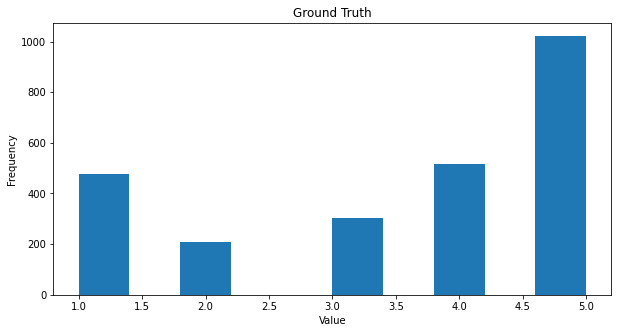

In [41]:
#what is the distrubution in ground truth scores like?
getHistogram(finaldf,'ratingScore', 'Ground Truth')

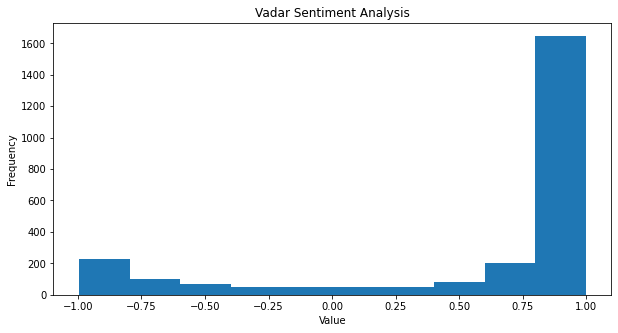

In [42]:
# what is the distrubtuion in vader scores like?
getHistogram(finaldf, 'vader', 'Vadar Sentiment Analysis')

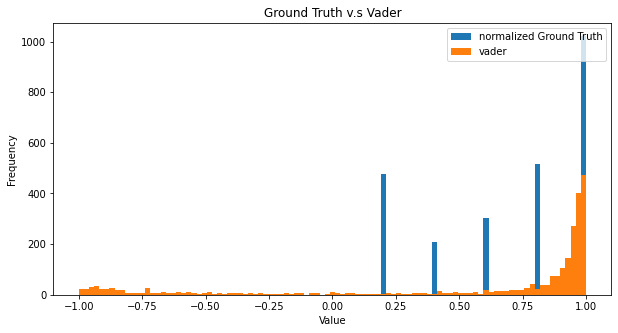

In [43]:
# how do the distrubutions compare between ground truth (normalized) and vader
getHistogram(finaldf, 'both', 'Ground Truth v.s Vader')

In [44]:
# How do often do the top negative and positive words overlap?
def plot_word_count_with_sentiment(topkpos, topkneg):
  tpdf = pd.DataFrame(topkpos)
  tndf = pd.DataFrame(topkneg)
  tpdf.columns =['word','count']
  tndf.columns =['word','count']
  tpdf['type'] = 'Positive'
  tndf['type'] = 'Negative'
  overlayhist = pd.concat([tpdf,tndf])
  
  fig = plt.figure(figsize=(15,5))
  sns.barplot(x="count", y='word', hue='type', data=overlayhist)

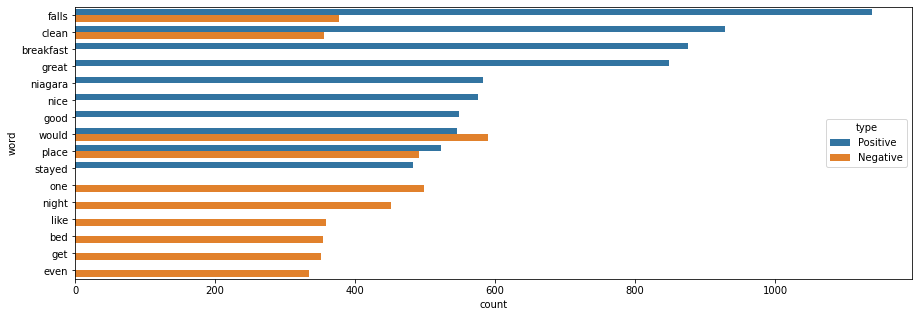

In [45]:
plot_word_count_with_sentiment(topkGroundPos, topkGroundNeg)

### Boxplots

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


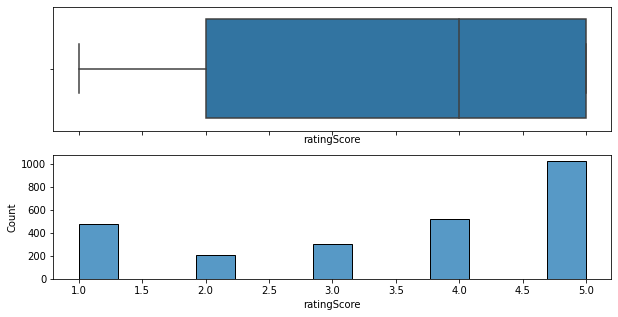

In [46]:
# What does the distribution of scores look like in a boxplot
data = finaldf['ratingScore']

fig, ax = plt.subplots(2,1,figsize=(10,5),sharex=True)
sns.boxplot(data,ax=ax[0])
sns.histplot(data,ax=ax[1]);

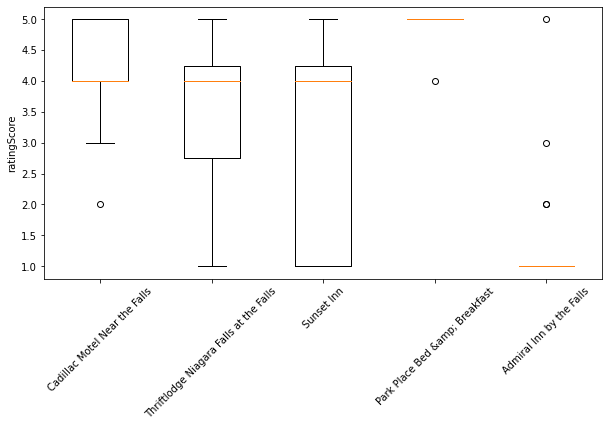

In [47]:
# how do the ratings compare for 5 hotels?
five_hotels = avg_rating_df[avg_rating_df['n_reviews'] > 10].sample(n=5,random_state=14)
five_hotels = five_hotels.index.values

hotel_list = []
for hotel in five_hotels:
  _hotel = finaldf.loc[finaldf['hotelName'] == hotel]['ratingScore']
  hotel_list.append(_hotel)


# multiple box plots on one figure
plt.figure(figsize=(10,5))
plt.boxplot(hotel_list)
plt.xticks(np.arange(1,6), five_hotels,rotation=45)
plt.ylabel('ratingScore')
plt.show()

### Scatter Plots


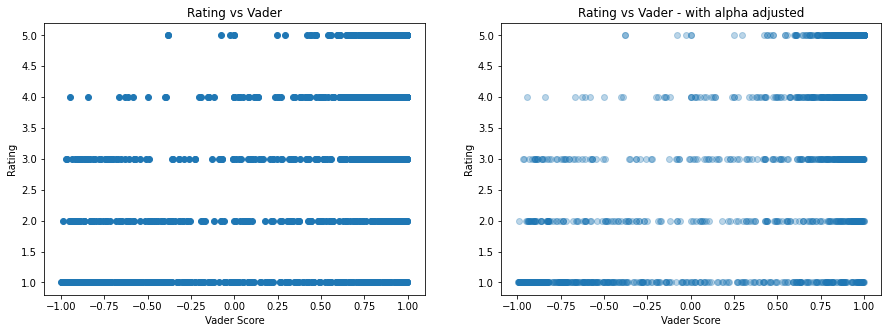

In [48]:
fig, ax = plt.subplots(1,2,figsize=(15,5),sharex=False,sharey=False)
rating_scores = finaldf['ratingScore'].values
vader_scores = finaldf['vader'].values
ax[0].plot(vader_scores, rating_scores,"o")
ax[1].plot(vader_scores, rating_scores,"o", alpha=0.3)

ax[0].set_title('Rating vs Vader')
ax[1].set_title('Rating vs Vader - with alpha adjusted')

for _ax in ax:
  _ax.set_ylabel('Rating')
  _ax.set_xlabel('Vader Score')

### Heatmaps

In [49]:
k = gaussian_kde(np.vstack([vader_scores, rating_scores]))
xi, yi = np.mgrid[vader_scores.min():vader_scores.max():vader_scores.size**0.5*1j,rating_scores.min():rating_scores.max():rating_scores.size**0.5*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))

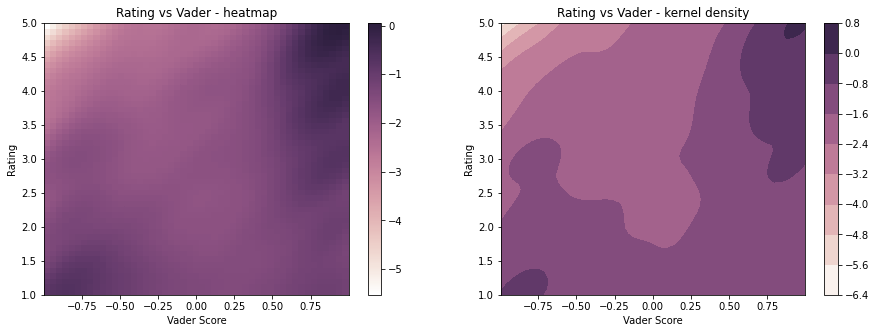

In [50]:
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))


b1 = ax1.pcolormesh(xi, yi, np.log10(zi.reshape(xi.shape)), cmap=cmap)
b2 = ax2.contourf(xi, yi, np.log10(zi.reshape(xi.shape)), cmap=cmap)

ax1.set_xlim(vader_scores.min(), vader_scores.max())
ax1.set_ylim(rating_scores.min(), rating_scores.max())
ax2.set_xlim(vader_scores.min(), vader_scores.max())
ax2.set_ylim(rating_scores.min(), rating_scores.max())

ax1.set_xlabel('Vader Score')
ax1.set_ylabel('Rating')

ax2.set_xlabel('Vader Score')
ax2.set_ylabel('Rating')

fig.colorbar(b1, ax=ax1)
fig.colorbar(b2, ax=ax2)

ax1.set_title('Rating vs Vader - heatmap')
ax2.set_title('Rating vs Vader - kernel density');

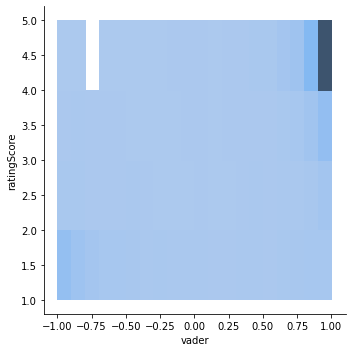

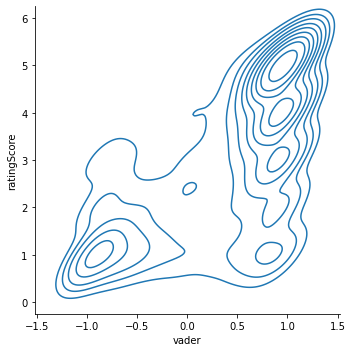

In [51]:


sns.displot(finaldf, y="ratingScore", x="vader", binwidth=(0.1, 1.0))
sns.displot(finaldf, y="ratingScore", x="vader", kind="kde" )


## Plotting of time-series data

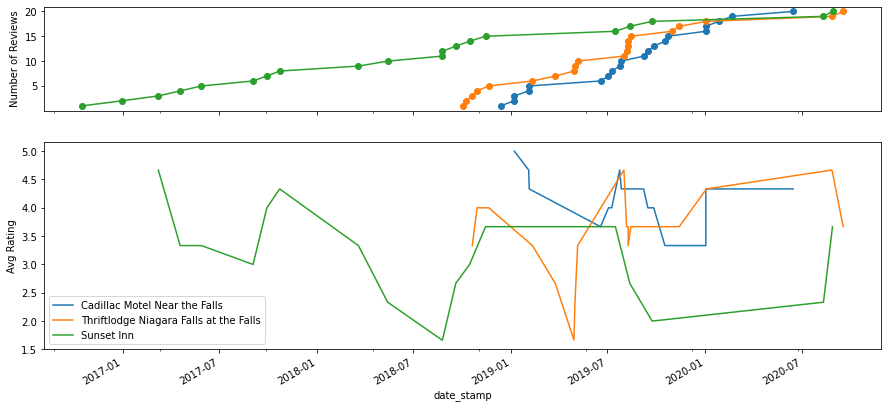

In [52]:
# It can be useful to see when reviews were being made and how the ratings changed using a running mean
fig, ax = plt.subplots(2, 1, figsize=(15,7),
                       sharex=True,
                       gridspec_kw={
                           'height_ratios': [1, 2]})

for hotel in five_hotels[:3]: 
  _df = hotelDf[hotelDf['hotelName']==hotel].set_index('date_stamp')
  _df.index = pd.to_datetime(_df.index)
  _df = _df.sort_index()
  _df['count'] = 1
  _df['count'].cumsum().plot(ax=ax[0],label=hotel, marker='o')
  _df['ratingScore'].rolling(3).mean().plot(ax=ax[1],label=hotel)

ax[1].set_ylabel('Avg Rating')
ax[0].set_ylabel('Number of Reviews')
plt.legend()

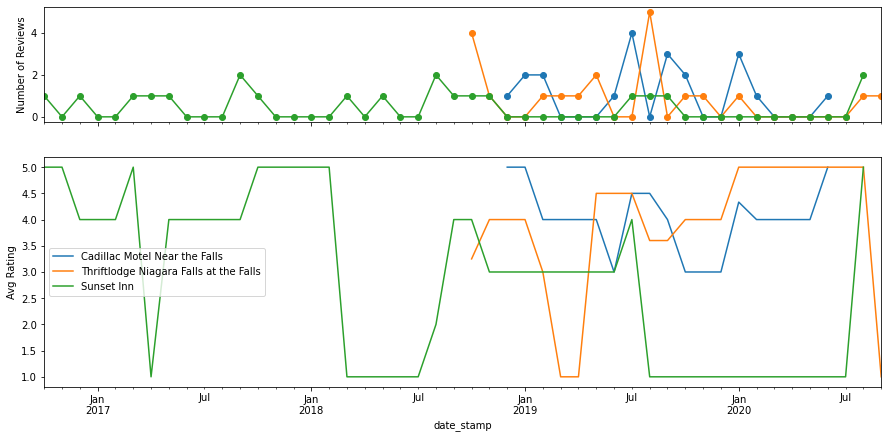

In [53]:
# It can be useful to see when reviews were being made and how the ratings changed
fig, ax = plt.subplots(2, 1, figsize=(15,7),
                       sharex=True,
                       gridspec_kw={
                           'height_ratios': [1, 2]})

for hotel in five_hotels[:3]: 
  _df = hotelDf[hotelDf['hotelName']==hotel].set_index('date_stamp')
  _df.index = pd.to_datetime(_df.index)
  _df = _df.sort_index()
  _df['count'] = 1
  _df_monthly = _df.groupby(pd.Grouper(freq='M')).agg({'count':'sum','ratingScore':'mean'})
  _df_monthly['ratingScore'] = _df_monthly['ratingScore'].fillna(method='ffill') # hold the last rating constant in months with no reviews
  _df_monthly['count'].plot(ax=ax[0],label=hotel, marker='o')
  _df_monthly['ratingScore'].plot(ax=ax[1],label=hotel)

ax[1].set_ylabel('Avg Rating')
ax[0].set_ylabel('Number of Reviews')
plt.legend()

# Alternative methods of breaking up text data
## Noun phrases

In [54]:
# Sample text
text = """The Buddha, the Godhead, resides quite as comfortably in the circuits of a digital
computer or the gears of a cycle transmission as he does at the top of a mountain
or in the petals of a flower. To think otherwise is to demean the Buddha...which is
to demean oneself."""

In [55]:
text = 'I have the faith in humanity .'

In [56]:
sentence_re = r'''(?x)          # set flag to allow verbose regexps
        (?:[A-Z]\.)+        # abbreviations, e.g. U.S.A.
      | \w+(?:-\w+)*        # words with optional internal hyphens
      | \$?\d+(?:\.\d+)?%?  # currency and percentages, e.g. $12.40, 82%
      | \.\.\.              # ellipsis
      | [][.,;"'?():_`-]    # these are separate tokens; includes ], [
    '''

# Part of Speech Tagging
# Google: https://en.wikipedia.org/wiki/Part-of-speech_tagging
tagger = PerceptronTagger()
pos_tag = tagger.tag

taggedToks = pos_tag(re.findall(r'\w+', text))
#taggedToks = pos_tag(nltk.regexp_tokenize(text, sentence_re))
taggedToks


[('I', 'PRP'),
 ('have', 'VBP'),
 ('the', 'DT'),
 ('faith', 'NN'),
 ('in', 'IN'),
 ('humanity', 'NN')]

In [57]:
# This grammar is described in the paper by S. N. Kim,
# T. Baldwin, and M.-Y. Kan.
# Evaluating n-gram based evaluation metrics for automatic
# keyphrase extraction.
# Technical report, University of Melbourne, Melbourne 2010.
grammar = r"""
    NBAR:
        {<NN.*|JJ>*<NN.*>}  # Nouns and Adjectives, terminated with Nouns
    NP:
        {<NBAR>}
        {<NBAR><IN><NBAR>}  # Above, connected with in/of/etc...
"""

grammar = r"""
    NBAR:
        {<NN.*|JJ>*<NN.*>}  # Nouns and Adjectives, terminated with Nouns
        
    NP:
        {<NBAR>}
        {<NBAR><IN><NBAR>}  # Above, connected with in/of/etc...
"""

In [58]:
# Create phrase tree
chunker = nltk.RegexpParser(grammar)
tree = chunker.parse(taggedToks)

In [59]:
# the parser and chunker put togeth the noun phrases
print(tree),

(S
  I/PRP
  have/VBP
  the/DT
  (NP (NBAR faith/NN))
  in/IN
  (NP (NBAR humanity/NN)))


(None,)

In [60]:
# to make the results more useable, we clean up the tree results shown above. 
lemmatizer = nltk.WordNetLemmatizer()
stemmer = nltk.stem.porter.PorterStemmer()
stopword_list = get_stop_words()

# generator, create item one a time
def get_terms(tree):
    for leaf in leaves(tree):
      
        term = [normalise(w) for w,t in leaf if acceptable_word(w) ]
        # Phrase only
        if len(term)>1:
            yield term

# generator, generate leaves one by one
def leaves(tree):
    """Finds NP (nounphrase) leaf nodes of a chunk tree."""
    for subtree in tree.subtrees(filter = lambda t: t.label()=='NP' or t.label()=='JJ' or t.label()=='RB'):
        yield subtree.leaves()

# stemming, lematizing, lower case... 
def normalise(word,lemmatizer=lemmatizer, stemmer=stemmer):
    """Normalises words to lowercase and stems and lemmatizes it."""
    word = word.lower()
    word = stemmer.stem(word)
    word = lemmatizer.lemmatize(word)
    return word

# stop-words and length control
def acceptable_word(word, stopword_list=stopword_list):
    """Checks conditions for acceptable word: length, stopword."""
    accepted = bool(2 <= len(word) <= 40
        and word.lower() not in stopword_list)
    return accepted

# Flatten phrase lists to get tokens for analysis
def flatten_phrase_lists(npTokenList):
    finalList =[]
    for phrase in npTokenList:
        token = ''
        for word in phrase:
            token += word + ' '
        finalList.append(token.rstrip())
    return finalList

In [61]:
# Traverse tree and get the cleaned noun phrase results
npTokenList = [word for word in get_terms(tree)]

npTokenList

[]

In [62]:
# need to flatten the lists back out
finalNPList = flatten_phrase_lists(npTokenList)
finalNPList

[]

In [63]:
def getTopKNP(df, kNPs):

    counter = Counter()
    reviews = df['reviewCol'].values

    for review in reviews:
            counter.update(flatten_phrase_lists([word
                            for word 
                            in get_terms(chunker.parse(pos_tag(re.findall(r'\w+', review)))) 
                            ]))
    topk = counter.most_common(kNPs)
    return topk


def NPdataFrameTransformation(hotelDf, reviewDF, topk):
    reviews = reviewDF['reviewCol'].values
    
    #Find out if a particular review has the word from topk list
    freqReview = []
    for i in range(len(reviews)):
        tempCounter = Counter(flatten_phrase_lists([word 
                                       for word 
                                       in get_terms(chunker.parse(pos_tag(re.findall(r'\w+',reviews[i]))))]))
        topkinReview = [1 if tempCounter[word] > 0 else 0 for (word,wordCount) in topk]
        freqReview.append(topkinReview)
        
        
    #Prepare freqReviewDf
    freqReviewDf = pd.DataFrame(freqReview)
    dfName = []
    for c in topk:
        dfName.append(c[0])
    freqReviewDf.columns = dfName
    finalreviewDf = reviewDF.join(freqReviewDf)
    finaldf = hotelDf[['hotelName','ratingScore','groundTruth']].join(finalreviewDf)
    return finaldf

In [64]:
topk_phrase = getTopKNP(finaldf, 50) 
topk_phrase[:10]

[('niagara fall', 318),
 ('front desk', 179),
 ('clifton hill', 139),
 ('minut walk', 90),
 ('hot tub', 61),
 ('first time', 49),
 ('park lot', 46),
 ('great place', 45),
 ('great locat', 44),
 ('next day', 44)]

In [65]:
finaldf_phrase = NPdataFrameTransformation(hotelDf, reviewDF, topk_phrase)
finaldf_phrase.head()

,hotelName,ratingScore,groundTruth,reviewCol,vader,niagara fall,front desk,clifton hill,minut walk,hot tub,first time,park lot,great place,great locat,next day,next time,next morn,free park,pool area,coffe maker,short walk,free breakfast,custom servic,hot water,good thing,good valu,credit card,min walk,water park,queen bed,comfort bed,reason price,great experi,free wifi,minut drive,good locat,first night,great time,jacuzzi tub,second night,air condition,outdoor pool,wonder host,clean bed,great view,nice place,delici breakfast,second floor,mini fridg,indoor pool,good price,fresh fruit,last minut,front door,bed sheet
0,Niagara Falls Motor Lodge,5,positive,"""The kindness of the owners\u002Fstaff of this place is what makes this place stand out from all other roadside motels. The rooms are clean and have the basic necessities for a stay (far better than a Motel 6 or a Super 8), the cost is a fraction of the Niagara Falls ripoffs, but the staff was amazing. We were planning a cycling loop and the owner graciously offered to let us leave our car in the parking lot for the 2 days that we cycled the Niagara loop. The adjoining pub is a delight fo...",0.9915,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Niagara Falls Motor Lodge,2,negative,"""We chose this motel because #1 Price was cheaper than the others that raised their rates on weekends, and #2 the location, although not ideal was close to the Niagara Parkway and their parking lots. The pluses for this facility are price, location, and personal service. The building itself needs renovation, upgrading, and a general sprucing up. There are breakfast and dinner restaurants nearby, and it is close-in to the main area. A place to sleep at a reasonable price",-0.4168,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Niagara Falls Motor Lodge,5,positive,"""Decided to take a weekend away with friends for a mini getaway. Needed two rooms. Hotel was very accommodating. Asked for two rooms close to each other. Rooms well kept and maintained. Staff very polite. Would recommend hotel. Will be back again. Thanks for the fun weekend away. Very affordable",0.9211,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Niagara Falls Motor Lodge,4,positive,"""We drove to Niagara Falls with no reservations or specific plans. Searching for a hotel on the phone, we found this one at a great price. The location was perfect if you don't want to be in the thick of the tourists. It's really in a little town just outside Niagara called Chipewa, where there are a few restaurants and pubs. The hotel owner waited for our arrival and showed us to our room, which was very clean and well appointed. Highly recommend if you want a simple inexpensive place to st...",0.9232,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Niagara Falls Motor Lodge,1,negative,"""Awful, the rooms were filthy, during my stay so far the room has not been cleaned nor the beds made. Reception is hardly open. Apparently my room only has 1 Key so my room cannot be serviced. Plaster is hanging off the ceiling. damp patches on ceiling. walls filthy and scuffed. Coffee maker next to to toilet within bathroom, hardly health and safe compliant or hygenic. Complete lack of assistance from staff. If you prepay your bill I would advise you to check it carefully as I was way overc...",-0.3744,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [66]:
pmiposdf_phrase = pmiForAllCal(finaldf_phrase,topk_phrase,'positive')

100%|██████████| 50/50 [00:00<00:00, 447.85it/s]


In [67]:
pmiposdf_phrase.sort_values('pmi',ascending=0).head(5)

,pmi
delici breakfast,0.49655
wonder host,0.445257
fresh fruit,0.435925
great place,0.425932
comfort bed,0.413168


In [68]:
pminegdf_phrase = pmiForAllCal(finaldf_phrase,topk_phrase,'negative')

100%|██████████| 50/50 [00:00<00:00, 443.52it/s]


In [69]:
pminegdf_phrase.sort_values('pmi',ascending=0).head(5)

,pmi
second night,0.812931
credit card,0.798332
bed sheet,0.755772
good thing,0.748852
next day,0.66616


In [70]:
text = 'i have faith in humanity .'

In [71]:

tagger = PerceptronTagger()
pos_tag = tagger.tag
taggedToks = pos_tag(re.findall(r'\w+', text))
taggedToks

[('i', 'NNS'),
 ('have', 'VBP'),
 ('faith', 'VBN'),
 ('in', 'IN'),
 ('humanity', 'NN')]

In [72]:
# Create phrase tree
chunker = nltk.RegexpParser(grammar)
tree = chunker.parse(taggedToks)

In [73]:
print(tree)

(S
  (NP (NBAR i/NNS))
  have/VBP
  faith/VBN
  in/IN
  (NP (NBAR humanity/NN)))


In [74]:
npTokenList = [word for word in get_terms(tree)]

In [75]:
flatten_phrase_lists(npTokenList)

[]

In [76]:
sentence_re = r'''(?x)          # set flag to allow verbose regexps
        (?:[A-Z]\.)+        # abbreviations, e.g. U.S.A.
      | \w+(?:-\w+)*        # words with optional internal hyphens
      | \$?\d+(?:\.\d+)?%?  # currency and percentages, e.g. $12.40, 82%
      | \.\.\.              # ellipsis
      | [][.,;"'?():_`-]    # these are separate tokens; includes ], [
    '''

toks = nltk.regexp_tokenize(text, sentence_re)
postoks = nltk.tag.pos_tag(toks)

tree = chunker.parse(taggedToks)
print(tree)

(S
  (NP (NBAR i/NNS))
  have/VBP
  faith/VBN
  in/IN
  (NP (NBAR humanity/NN)))


In [77]:
text = """The Buddha, the Godhead, resides quite as comfortably in the circuits of a digital
computer or the gears of a cycle transmission as he does at the top of a mountain
or in the petals of a flower. To think otherwise is to demean the Buddha...which is
to demean oneself."""

#text = 'i have the faith in humanity.'

# Used when tokenizing words
sentence_re = r'''(?x)          # set flag to allow verbose regexps
        (?:[A-Z]\.)+        # abbreviations, e.g. U.S.A.
      | \w+(?:-\w+)*        # words with optional internal hyphens
      | \$?\d+(?:\.\d+)?%?  # currency and percentages, e.g. $12.40, 82%
      | \.\.\.              # ellipsis
      | [][.,;"'?():_`-]    # these are separate tokens; includes ], [
    '''

lemmatizer = nltk.WordNetLemmatizer()
stemmer = nltk.stem.porter.PorterStemmer()

#Taken from Su Nam Kim Paper...
grammar = r"""
    NBAR:
        {<NN.*|JJ>*<NN.*>}  # Nouns and Adjectives, terminated with Nouns
        
    NP:
        {<NBAR>}
        {<NBAR><IN><NBAR>}  # Above, connected with in/of/etc...
"""
chunker = nltk.RegexpParser(grammar)

toks = nltk.regexp_tokenize(text, sentence_re)
postoks = nltk.tag.pos_tag(toks)

print(postoks)

tree = chunker.parse(postoks)

from nltk.corpus import stopwords
stopwords = stopwords.words('english')


def leaves(tree):
    """Finds NP (nounphrase) leaf nodes of a chunk tree."""
    for subtree in tree.subtrees(filter = lambda t: t.label()=='NP'):
        yield subtree.leaves()

def normalise(word):
    """Normalises words to lowercase and stems and lemmatizes it."""
    word = word.lower()
    word = stemmer.stem(word)
    word = lemmatizer.lemmatize(word)
    return word

def acceptable_word(word):
    """Checks conditions for acceptable word: length, stopword."""
    accepted = bool(2 <= len(word) <= 40
                    and word.lower() not in stopwords)
    return accepted


def get_terms(tree):
    for leaf in leaves(tree):
      
        term = [ normalise(w) for w,t in leaf if acceptable_word(w) ]
        yield term

terms = get_terms(tree)

for term in terms:
    for word in term:
        print(word)
    print(term)

npTokenList = [word for word in get_terms(tree)]

[('The', 'DT'), ('Buddha', 'NNP'), (',', ','), ('the', 'DT'), ('Godhead', 'NNP'), (',', ','), ('resides', 'VBZ'), ('quite', 'RB'), ('as', 'IN'), ('comfortably', 'RB'), ('in', 'IN'), ('the', 'DT'), ('circuits', 'NNS'), ('of', 'IN'), ('a', 'DT'), ('digital', 'JJ'), ('computer', 'NN'), ('or', 'CC'), ('the', 'DT'), ('gears', 'NNS'), ('of', 'IN'), ('a', 'DT'), ('cycle', 'NN'), ('transmission', 'NN'), ('as', 'IN'), ('he', 'PRP'), ('does', 'VBZ'), ('at', 'IN'), ('the', 'DT'), ('top', 'NN'), ('of', 'IN'), ('a', 'DT'), ('mountain', 'NN'), ('or', 'CC'), ('in', 'IN'), ('the', 'DT'), ('petals', 'NNS'), ('of', 'IN'), ('a', 'DT'), ('flower', 'NN'), ('.', '.'), ('To', 'TO'), ('think', 'VB'), ('otherwise', 'RB'), ('is', 'VBZ'), ('to', 'TO'), ('demean', 'VB'), ('the', 'DT'), ('Buddha', 'NNP'), ('...', ':'), ('which', 'WDT'), ('is', 'VBZ'), ('to', 'TO'), ('demean', 'VB'), ('oneself', 'PRP'), ('.', '.')]
buddha
['buddha']
godhead
['godhead']
circuit
['circuit']
digit
comput
['digit', 'comput']
gear
['gea

In [78]:
# Flatten phrase lists to get tokens for analysis
def flatten_phrase_lists(npTokenList):
    finalList =[]
    for phrase in npTokenList:
        token = ''
        for word in phrase:
            token += word + ' '
        finalList.append(token.rstrip())
    return finalList

In [79]:
flatten_phrase_lists(npTokenList)

['buddha',
 'godhead',
 'circuit',
 'digit comput',
 'gear',
 'cycl transmiss',
 'top',
 'mountain',
 'petal',
 'flower',
 'buddha']

In [80]:
[word for word in get_terms(tree)]

[['buddha'],
 ['godhead'],
 ['circuit'],
 ['digit', 'comput'],
 ['gear'],
 ['cycl', 'transmiss'],
 ['top'],
 ['mountain'],
 ['petal'],
 ['flower'],
 ['buddha']]

In [81]:
nltk.download('brown')
nltk.download('punkt')

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [82]:
from textblob import TextBlob
 
#Extract noun
blob = TextBlob("Canada is a country in the northern part of North America.")
for nouns in blob.noun_phrases:
    print(nouns)
blob = TextBlob("I have faith in humanity.")
for nouns in blob.noun_phrases:
    print(nouns)

canada
northern part
america


In [83]:
import spacy

nlp = spacy.load("en_core_web_sm")

doc = nlp("We try to explicitly describe the geometry of the edges of the images.")

for np in doc.noun_chunks: # use np instead of np.text
    print(np)

We
the geometry
the edges
the images


In [84]:
import spacy

nlp = spacy.load("en_core_web_sm")

doc = nlp("i have the faith in humanity .")

for np in doc.noun_chunks: # use np instead of np.text
    print(np)

i
the faith
humanity


In [85]:
for token in doc:
    print(token.text, token.lemma_, token.pos_, token.tag_, token.dep_,
            token.shape_, token.is_alpha, token.is_stop)

i i PRON PRP nsubj x True True
have have AUX VBP ROOT xxxx True True
the the DET DT det xxx True True
faith faith NOUN NN dobj xxxx True False
in in ADP IN prep xx True True
humanity humanity NOUN NN pobj xxxx True False
. . PUNCT . punct . False False
